<a href="https://colab.research.google.com/github/brunocrt/bike-riding-prediction/blob/master/Bike_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a simple fully connected Neural Network with TensorFlow 2

In this exercise, we will build a Neural Network to predict daily bike rental ridership.

Example code is provided below, so you will be able to test, modify and evolve it.

You can see the complete dataset description here:
https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Shortcuts in both modes:
* Shift + Enter: run the current cell, select below.
* Ctrl + Enter: run selected cells.
* Alt + Enter: run the current cell, insert below.
* Ctrl + S: save and checkpoint.

Mac users:  
* Alt: option ⌥
* Ctrl: command key ⌘

You can get a full list of shortcuts here: https://towardsdatascience.com/jypyter-notebook-shortcuts-bf0101a98330



In [1]:
print('Try me again')

Try me again


In [3]:
# Import the dependencies you will need in this exercise
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow
import tensorflow as tf

# Avoid TF2 warning about float64->float32
tf.keras.backend.set_floatx('float64') 
# Increase default plot size
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

# Load and prepare data

The first step when working with neural networks is preparing the data. This step can be more important than the neural network architecture or how the training is done.

For instance, variables on different scales make it difficult for the network to learn efficiently. 

Let's start loading the data and inspecting it.

In [4]:
#Complete dataset
data_path ="https://gist.githubusercontent.com/gonzaloruizdevilla/435806f965fd05f23a6710adacd85e04/raw/8f3b638b5b9b69de1cd3a9906b6acec24043935c/hour.csv"

rides = pd.read_csv(data_path)

In [5]:
rides.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


# Reviewing the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the cnt column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

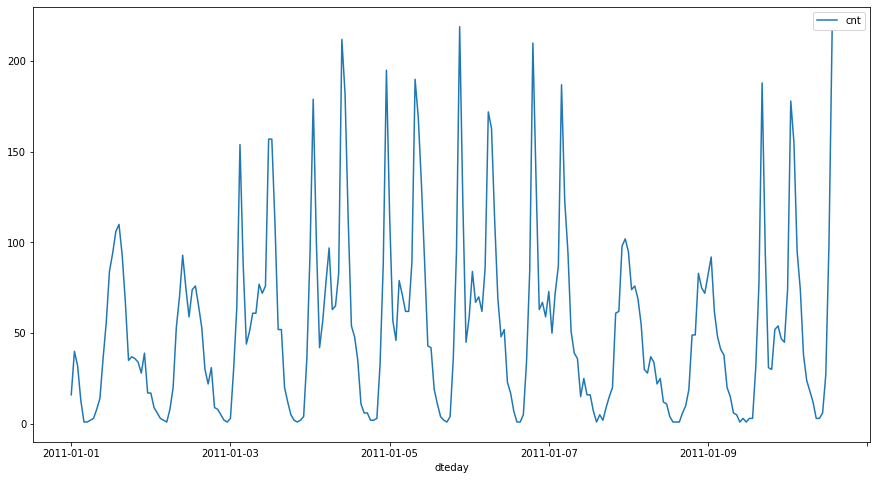

In [6]:
rides[ :24*10 ].plot(x='dteday', y='cnt')

Pandas provide very interesting tools to better understand the data. Some of the are really easy to use!

In [7]:
rides.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## Dummy variables

Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to get_dummies().

In [8]:
data = rides.copy()
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(data[each], prefix=each, drop_first=False)
    data = pd.concat([data, dummies], axis=1)
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = data.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#Scaling target variables

To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [9]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [10]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.




In [11]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]


### Separate the data into features and targets

We create split each dataset in two, one with the input features and another with the target output

In [12]:
# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [13]:
targets

,cnt,casual,registered
0,-0.956312,-0.662736,-0.930162
1,-0.823998,-0.561326,-0.804632
2,-0.868103,-0.622172,-0.837666
3,-0.972851,-0.662736,-0.949983
4,-1.039008,-0.723582,-1.009445
...,...,...,...
16870,2.351522,0.047131,2.802727
16871,2.064843,-0.317944,2.578093
16872,1.309554,-0.358507,1.686163
16873,0.609396,-0.459917,0.880124


### Training and validation data

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).
However, we won't do it this explicitly as we can let tensorflow do the split for us.

In [14]:
# Hold out the last 60 days or so of the remaining data as a validation set
# train_features, train_targets = features[:-60*24], targets[:-60*24]
# val_features, val_targets = features[-60*24:], targets[-60*24:]

# Building the network

Not it is time to build your network. In order to avoid tons of technical details, we will use the Keras API that comes with TensorFlow. Keras provides a high level API for building, training, exporting and importing deep neural networks.

We will try to predict to total number of ride shares cnt.

In [15]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(56, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

We then need to compile the model, providing at least an optimizer and a loss function.

In [16]:
model.compile(
    # Optimizer
    optimizer = tf.keras.optimizers.SGD(), 
    # Loss function to minimize
    loss= 'mse',
)

In [17]:
history = model.fit(features, targets['cnt'], validation_split=0.1, epochs=20)


Epoch 1/20
475/475 [==============================] - 1s 2ms/step - loss: 0.5985 - val_loss: 0.7381
Epoch 2/20
475/475 [==============================] - 1s 1ms/step - loss: 0.3183 - val_loss: 0.4865
Epoch 3/20
475/475 [==============================] - 1s 1ms/step - loss: 0.2393 - val_loss: 0.4178
Epoch 4/20
475/475 [==============================] - 1s 1ms/step - loss: 0.2094 - val_loss: 0.4144
Epoch 5/20
475/475 [==============================] - 1s 1ms/step - loss: 0.1860 - val_loss: 0.3598
Epoch 6/20
475/475 [==============================] - 1s 1ms/step - loss: 0.1623 - val_loss: 0.3303
Epoch 7/20
475/475 [==============================] - 1s 1ms/step - loss: 0.1394 - val_loss: 0.2795
Epoch 8/20
475/475 [==============================] - 1s 1ms/step - loss: 0.1189 - val_loss: 0.2474
Epoch 9/20
475/475 [==============================] - 1s 1ms/step - loss: 0.1032 - val_loss: 0.2269
Epoch 10/20
475/475 [==============================] - 1s 1ms/step - loss: 0.0917 - val_loss: 0.2196

The fit method returns a history object that we can use to understand how the training performed.


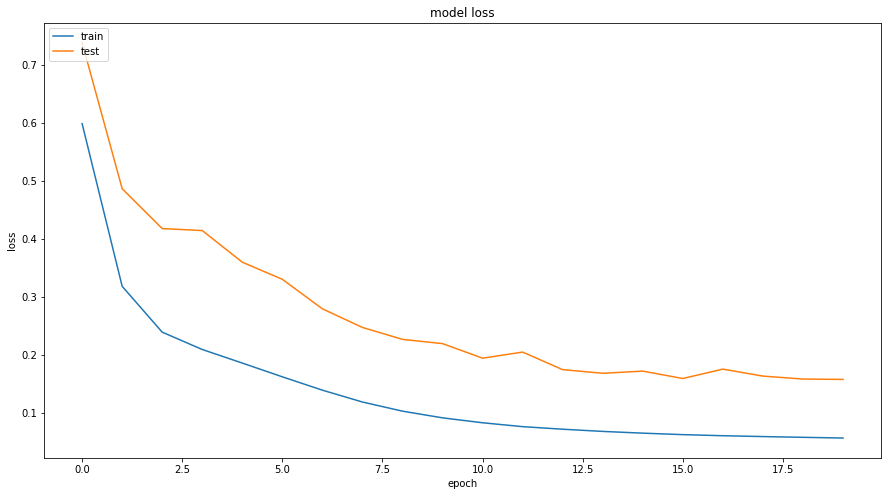

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Check out the predictions



Once we have trained the model, we can evaluate it with the test data, that the model has never seen.

In [19]:
model.evaluate(test_features,  test_targets['cnt'], verbose=2)

16/16 - 0s - loss: 0.1735


0.17349436264189463

Let's plot the prediction of the test data against the expected data. This will provide a clear visual feedback about the model. Is it making good predictions?

In [20]:
# First we make the predictions and scale them
scaled_test_predictions = model.predict(test_features) * scaled_features['cnt'][1] + scaled_features['cnt'][0]


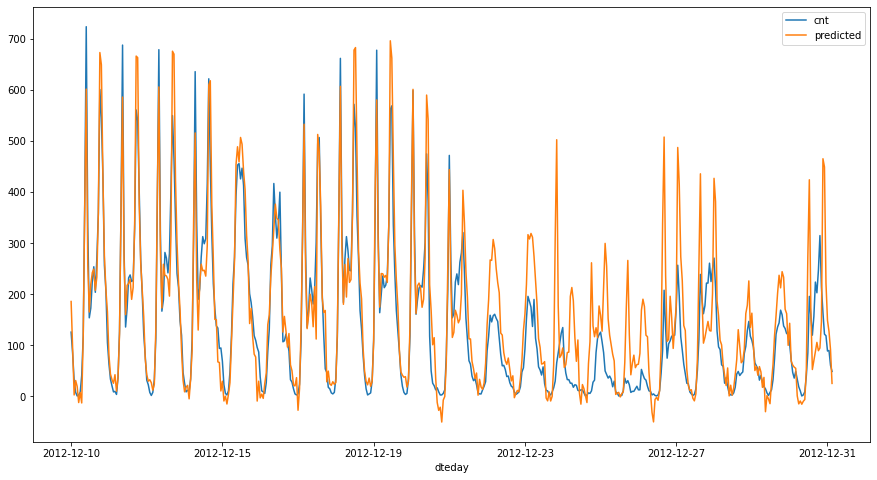

In [21]:
# And we plot the predictions against the real values
test_rides = rides[-21*24:]
plot_data = test_rides[['dteday', 'cnt']].copy()
plot_data['predicted'] = scaled_test_predictions.flatten()
plot_data.plot(x='dteday',y=['cnt','predicted'])